In [2]:
from pickle import TRUE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchtext.vocab import GloVe
import spacy
import io
import jsonlines
import json
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
import fasttext
import re
from spacy.language import Language
from spacy.tokens import Doc
from gensim import models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.bernoulli import Bernoulli
import seaborn as sns

cpu = torch.device('cpu')


use_word2vec = True
use_glove = True
use_fasttext = True
use_word_dropout = False

LEARNING_RATE = 0.001

word_vector_types_count = 0
if use_word2vec:
    word_vector_types_count += 1
if use_glove:
    word_vector_types_count += 1
if use_fasttext:
    word_vector_types_count += 1


if torch.has_mps:
    device = torch.device('mps')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')


EMBED_DIM = 300
HIDDEN_LAYER_DIM = 128
NUM_EPOCHS = 200
BATCH_SIZE = 32
EXPAND_CONTRACTIONS = False
PATIENCE_PARAMETER = 4
VALIDATION_LOSS_STEP = 5

In [3]:
glove = None
fasttext_model = None
word2vec_model = None

if use_glove:
    glove = GloVe()
if use_fasttext:
    fasttext_model = fasttext.load_model('./crawl-300d-2M-subword/crawl-300d-2M-subword.bin')
if use_word2vec:
    word2vec_model = models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin',binary=True)

In [4]:
def expand_contractions_text(text):    
    flags = re.IGNORECASE | re.MULTILINE
    text = re.sub(r'`', "'", text, flags = flags)
    ## starts / ends with '
    text = re.sub(
        r"(\s|^)'(aight|cause)(\s|$)",
        '\g<1>\g<2>\g<3>',
        text, flags = flags
    )
    text = re.sub(
        r"(\s|^)'t(was|is)(\s|$)", r'\g<1>it \g<2>\g<3>',
        text,
        flags = flags
    )
    text = re.sub(
        r"(\s|^)ol'(\s|$)",
        '\g<1>old\g<2>',
        text, flags = flags
    )
        
    text = re.sub(r"\b(aight)\b", 'alright', text, flags = flags)
    text = re.sub(r'\bcause\b', 'because', text, flags = flags)
    text = re.sub(r'\b(finna|gonna)\b', 'going to', text, flags = flags)
    text = re.sub(r'\bgimme\b', 'give me', text, flags = flags)
    text = re.sub(r"\bgive'n\b", 'given', text, flags = flags)
    text = re.sub(r"\bhowdy\b", 'how do you do', text, flags = flags)
    text = re.sub(r"\bgotta\b", 'got to', text, flags = flags)
    text = re.sub(r"\binnit\b", 'is it not', text, flags = flags)
    text = re.sub(r"\b(can)(not)\b", r'\g<1> \g<2>', text, flags = flags)
    text = re.sub(r"\bwanna\b", 'want to', text, flags = flags)
    text = re.sub(r"\bmethinks\b", 'me thinks', text, flags = flags)
    text = re.sub(r"\bo'er\b", r'over', text, flags = flags)
    text = re.sub(r"\bne'er\b", r'never', text, flags = flags)
    text = re.sub(r"\bo'?clock\b", 'of the clock', text, flags = flags)
    text = re.sub(r"\bma'am\b", 'madam', text, flags = flags)
    text = re.sub(r"\bgiv'n\b", 'given', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\bg'?day\b", 'good day', text, flags = flags)
    text = re.sub(r"\b(ain|amn)'?t\b", 'am not', text, flags = flags)
    text = re.sub(r"\b(are|can)'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(let)'?s\b", r'\g<1> us', text, flags = flags)
    text = re.sub(r"\by'all'dn't've'd\b", 'you all would not have had', text, flags = flags)
    text = re.sub(r"\by'all're\b", 'you all are', text, flags = flags)
    text = re.sub(r"\by'all'd've\b", 'you all would have', text, flags = flags)
    text = re.sub(r"(\s)y'all(\s)", r'\g<1>you all\g<2>', text, flags = flags)  
    text = re.sub(r"\b(won)'?t\b", 'will not', text, flags = flags)
    text = re.sub(r"\bhe'd\b", 'he had', text, flags = flags)
    text = re.sub(r"\b(I|we|who)'?d'?ve\b", r'\g<1> would have', text, flags = flags)
    text = re.sub(r"\b(could|would|must|should|would)n'?t'?ve\b", r'\g<1> not have', text, flags = flags)
    text = re.sub(r"\b(he)'?dn'?t'?ve'?d\b", r'\g<1> would not have had', text, flags = flags)
    text = re.sub(r"\b(daren|daresn|dasn)'?t", 'dare not', text, flags = flags)
    text = re.sub(r"\b(he|how|i|it|she|that|there|these|they|we|what|where|which|who|you)'?ll\b", r'\g<1> will', text, flags = flags)
    text = re.sub(r"\b(everybody|everyone|he|how|it|she|somebody|someone|something|that|there|this|what|when|where|which|who|why)'?s\b", r'\g<1> is', text, flags = flags)
    text = re.sub(r"\b(I)'?m'a\b", r'\g<1> am about to', text, flags = flags)
    text = re.sub(r"\b(I)'?m'o\b", r'\g<1> am going to', text, flags = flags)
    text = re.sub(r"\b(I)'?m\b", r'\g<1> am', text, flags = flags)
    text = re.sub(r"\bshan't\b", 'shall not', text, flags = flags)
    text = re.sub(r"\b(are|could|did|does|do|go|had|has|have|is|may|might|must|need|ought|shall|should|was|were|would)n'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(could|had|he|i|may|might|must|should|these|they|those|to|we|what|where|which|who|would|you)'?ve\b", r'\g<1> have', text, flags = flags)
    text = re.sub(r"\b(how|so|that|there|these|they|those|we|what|where|which|who|why|you)'?re\b", r'\g<1> are', text, flags = flags)
    text = re.sub(r"\b(I|it|she|that|there|they|we|which|you)'?d\b", r'\g<1> had', text, flags = flags)
    text = re.sub(r"\b(how|what|where|who|why)'?d\b", r'\g<1> did', text, flags = flags)    
    return text


class ExpandContractionsClass:
    def __init__(self, nlp: Language):
        self.nlp = nlp
    
    def __call__(self,doc: Doc):
        text = doc.text
        return self.nlp.make_doc(expand_contractions_text(text))

    
@Language.factory("expand_contractions_component")
def create_expand_contractions_component(nlp : Language, name: str):
    return ExpandContractionsClass(nlp)
 

In [5]:
nlp = spacy.load("en_core_web_sm")
if EXPAND_CONTRACTIONS:
    nlp.add_pipe("expand_contractions_component",before='tagger')


In [8]:

def preprocess_text(text):    
    words = nlp(text)
    #sentence = [token.text_with_ws for token in words if not token.is_punct]
    sentence  = " ".join([token.text for token in words if not token.is_punct ]).strip()
    sentence = sentence.lower()
    return sentence

def process_training_data():
    negative_reviews = io.open('./Train.neg',encoding='latin-1').readlines()
    positive_reviews = io.open('./Train.pos',encoding='latin-1').readlines()
    with jsonlines.open('train.jsonl',mode='w') as writer:

        for review in positive_reviews:
            processed_text = preprocess_text(review)
            d = {'text': processed_text , 'sentiment': 1}
            writer.write(d)
        for review in negative_reviews:
            processed_text = preprocess_text(review)
            d = {'text': processed_text , 'sentiment': 0}
            writer.write(d)
process_training_data()


- Almost equal distribution of the positive and negative classes

In [7]:
from torch.utils.data import DataLoader,Dataset

class ReviewDataSet(Dataset):

    def __init__(self,file):
        super().__init__()
        
        self.file = file
        self.data = []
        with open(self.file) as f:
            for line in f:
                sample = json.loads(line)
                self.data.append([sample['text'],sample['sentiment']])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

    

dataset = ReviewDataSet('train.jsonl') 

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size


train_dataset = torch.utils.data.Subset(dataset,range(train_size))
validation_dataset = torch.utils.data.Subset(dataset,range(train_size,train_size+test_size))
#train_dataset,validation_dataset = random_split(dataset,[train_size,test_size])

train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = DataLoader(validation_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [10]:
def getWordEmbeddings(batch_data,dicts):
    
    word2vec,glove,fast_text = dicts

    if(len(batch_data)==2):
        reviews = batch_data[0]
        sentiment = batch_data[1]
    else:
        reviews = batch_data[0]
        sentiment = None
    
    reviews_tensor = []
    lengths = []
    for review in reviews:
        
        preprocessed_review_list = []
        i = 0
        review_doc = nlp(review)
        for token in review_doc:
            if token.text == '\'s':
                if i>0 and review_doc[i-1].pos_!='PROPN':
                    preprocessed_review_list[i-1] = preprocessed_review_list[i-1] + '\'s'
            elif token.text == '\'nt':
                if i>0:
                    preprocessed_review_list[i-1] = preprocessed_review_list[i-1] + '\'nt'
            else:
                preprocessed_review_list.append(token.text) 
                i+=1

        new_review = " ".join(preprocessed_review_list)
        
        words = new_review.split()
        words_tensor = []
        lengths.append(len(words))
        for word in words:
            #words_tensor.append(glove.__getitem__(word))
            word_embeddings = []
            if use_word2vec:
                try:
                    word_embeddings.append(torch.tensor(word2vec.get_vector(word)))
                except:
                    word_embeddings.append(torch.zeros(EMBED_DIM,))
            if use_glove:
                word_embeddings.append(glove.__getitem__(word))
            if use_fasttext:
                word_embeddings.append(torch.tensor(fast_text.get_word_vector(word)))
            word_tensor = torch.stack(word_embeddings)
            word_tensor = word_tensor.squeeze()
            words_tensor.append(word_tensor)            
        reviews_tensor.append(torch.stack(words_tensor,dim=0))
    
    mask = torch.zeros((len(lengths),max(lengths)))
    for i in range(len(lengths)):
        mask[i,:lengths[i]] = 1.0
    
    return (pad_sequence(reviews_tensor,batch_first=True),mask,sentiment)




/Users/depressedcoder/environments/gymenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/depressedcoder/environments/gymenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


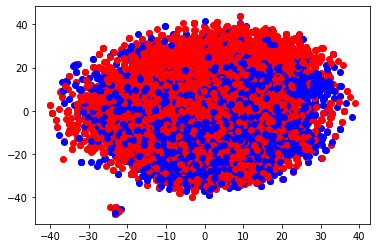

In [11]:
def plot_sentence_embeddings_tsne(index):
    
    all_vectors = None
    all_labels = None



    for i,data in enumerate(train_dataloader,0):
        input_reviews , input_mask , output_labels = getWordEmbeddings(data,(word2vec_model,glove,fasttext_model))
        inp_lengths = torch.sum(input_mask,-1,keepdim=True).int()
        
        input_reviews  = input_reviews[:,:,index,:]
        total = torch.sum(input_reviews*(input_mask.unsqueeze(2)),axis=1)
        vector_average = total / inp_lengths
        vector_average = vector_average.numpy()

        if(all_vectors is None):
            all_vectors = vector_average
            all_labels = output_labels.numpy()
        else:
            all_vectors = np.append(all_vectors,vector_average,axis=0)
            all_labels = np.append(all_labels,output_labels.numpy(),axis=0)

    
    tsne = TSNE()
    out = tsne.fit_transform(all_vectors)

    for i in range(len(out)):
        if int(all_labels[i])==1:
            plt.scatter(out[i][0],out[i][1],c='r')
        else:
            plt.scatter(out[i][0],out[i][1],c='b')
    plt.show()


plot_sentence_embeddings_tsne(0)


/Users/depressedcoder/environments/gymenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/depressedcoder/environments/gymenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


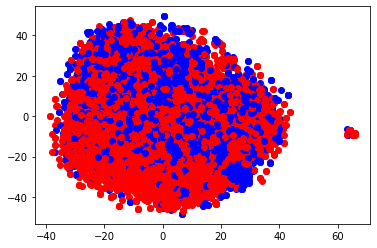

In [12]:
plot_sentence_embeddings_tsne(1)

/Users/depressedcoder/environments/gymenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/depressedcoder/environments/gymenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


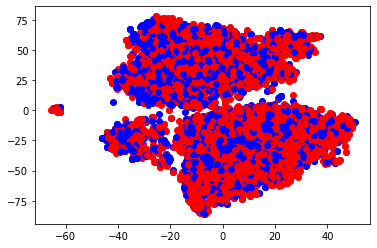

In [13]:
plot_sentence_embeddings_tsne(2)

In [14]:
class DAN(nn.Module):

    def __init__(self,embed_dim=EMBED_DIM,hidden_dim = HIDDEN_LAYER_DIM, droput_prob = 0.3):
        super().__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(self.embed_dim,self.hidden_dim)
        #self.fc = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim,1)
        self.sigmoid  = nn.Sigmoid()
        self.word_dropout_prob = droput_prob

        if(word_vector_types_count > 1) :
           self.importance_weights = nn.Linear(word_vector_types_count*EMBED_DIM,word_vector_types_count)
        

    def forward(self,inp,inp_mask):
        
        
        inp_lengths = torch.sum(inp_mask,-1,keepdim=True).int()
        if use_word_dropout:
            for i in range(inp_lengths.shape[0]):
                dist = Bernoulli(self.word_dropout_prob).sample((int(inp_lengths[i]),))
                while torch.count_nonzero(dist) == 0:
                    dist = Bernoulli(self.word_dropout_prob).sample((int(inp_lengths[i]),))
                inp_mask[i,:int(inp_lengths[i])]  = dist
                inp_lengths[i,0] = int(torch.sum(inp_mask[i]))
                #print(inp_mask)
                #inp_lengths = torch.sum(inp_mask,-1,keepdim=True)
        if word_vector_types_count > 1:
            input = inp.view((inp.shape[0],inp.shape[1],-1))
            out = self.importance_weights(input)
            weights = F.softmax(out,dim=2).unsqueeze(3)
            weights_multiplied_vector = weights * inp
            inp = torch.sum(weights_multiplied_vector,dim=2)

        total = torch.sum(inp*(inp_mask.unsqueeze(2)),axis=1)
        vector_average = total / inp_lengths
        ans = F.relu(self.fc1(vector_average))
        #ans = F.relu(self.fc(ans))
        ans = self.sigmoid(self.fc2(ans))
        return ans
    


In [ ]:
'''inp = torch.randn((2,3,5))
mask = torch.tensor([[1.0,0.0,0.0],[1.0,0.0,1.0]])

print(inp)'''

In [10]:
# Training loop
dan = DAN(EMBED_DIM,HIDDEN_LAYER_DIM)

criterion = nn.BCELoss()
optimizer = optim.Adagrad(dan.parameters(),lr=LEARNING_RATE)
#optimizer = optim.Adam(dan.parameters(),lr=LEARNING_RATE)



validation_losses = []
validation_accuracy = []
training_losses = []

best_validation_loss = 1000.0
validation_loss_not_decreased_steps = 0

for e in range(NUM_EPOCHS):
    if validation_loss_not_decreased_steps >= PATIENCE_PARAMETER:
        break

    training_loss = 0.0
    size = 0
    dan.train()

    for i,data in enumerate(train_dataloader,0):
        
        optimizer.zero_grad()
        
        input_reviews , input_mask , output_labels = getWordEmbeddings(data,(word2vec_model,glove,fasttext_model))
        #print(input_mask)
        output = dan(input_reviews,input_mask).squeeze()
        #print(output)
        loss = criterion(output,output_labels.float())

        training_loss += loss.item()
        loss.backward()
        optimizer.step()   
     
    
    if e%VALIDATION_LOSS_STEP==0:
        dan.eval()
        correct_count = 0
        validation_loss = 0

        val_size = 0
        for i,data in enumerate(val_dataloader,0):
            input_reviews,input_mask,output_labels = getWordEmbeddings(data,(word2vec_model,glove,fasttext_model))
            output = dan(input_reviews,input_mask).squeeze()
            loss = criterion(output,output_labels.float())
            validation_loss += loss.item()
            nearest_class = torch.round(output)
            correct = (nearest_class == output_labels.float()).float()
            
            correct_count += correct.sum()
        correct_count = int(correct_count)
        
        current_validation_loss = validation_loss/len(validation_dataset)

        if current_validation_loss <= best_validation_loss:
            validation_loss_not_decreased_steps = 0
            torch.save(dan.state_dict(),'best_model.pth')
            best_validation_loss = current_validation_loss

        elif current_validation_loss < validation_losses[-1]:
            validation_loss_not_decreased_steps = 0
        else:
            validation_loss_not_decreased_steps+=1

        validation_losses.append(validation_loss/len(validation_dataset))
        validation_accuracy.append(100*(correct_count/len(validation_dataset)))


        print("Validation Loss = " + str(validation_loss/len(validation_dataset)) + " Validation Set Accuracy = " + str(100*(correct_count/len(validation_dataset))))
    training_losses.append(training_loss/len(train_dataset))
    print("Epoch " + str(e) + "; Training Loss (averaged) = " + str(training_loss/len(train_dataset) ))


Validation Loss = 0.02919996926188469 Validation Set Accuracy = 1.0999999999999999
Epoch 0; Training Loss (averaged) = 0.020066143169999124
Epoch 1; Training Loss (averaged) = 0.018712409161031247
Epoch 2; Training Loss (averaged) = 0.017812588926404714
Epoch 3; Training Loss (averaged) = 0.017151725489646195
Epoch 4; Training Loss (averaged) = 0.016668593186885117
Validation Loss = 0.023738481134176256 Validation Set Accuracy = 46.0
Epoch 5; Training Loss (averaged) = 0.016306143902242182
Epoch 6; Training Loss (averaged) = 0.016025592092424632
Epoch 7; Training Loss (averaged) = 0.015801503859460355
Epoch 8; Training Loss (averaged) = 0.015618785697966814
Epoch 9; Training Loss (averaged) = 0.0154664044380188
Validation Loss = 0.02266443619132042 Validation Set Accuracy = 53.800000000000004
Epoch 10; Training Loss (averaged) = 0.015337364215403795
Epoch 11; Training Loss (averaged) = 0.015227921657264233
Epoch 12; Training Loss (averaged) = 0.015132684465497733
Epoch 13; Training Los

KeyboardInterrupt: 

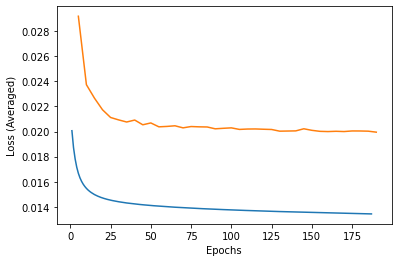

In [11]:
epochs = np.linspace(1,len(training_losses),len(training_losses))
plt.plot(epochs,training_losses) 
epochs = 5*np.linspace(1,len(validation_accuracy),len(validation_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Loss (Averaged)')
plt.plot(epochs,validation_losses)
plt.show()


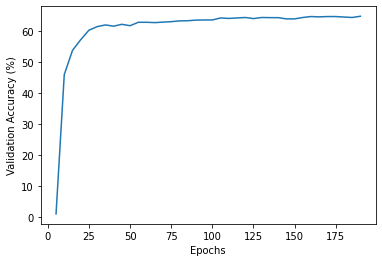

In [12]:
epochs = 5*np.linspace(1,len(validation_accuracy),len(validation_accuracy))
plt.plot(epochs,validation_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.show()

In [15]:
dan_model = DAN()
dan_model.load_state_dict(torch.load('best_model.pth'))
dan_model.eval()

correct_count = 0


def test(filename):
    reviews = open(filename,'r',encoding='latin-1').readlines()
    for i in range(len(reviews)):
        r = reviews[i]
        reviews[i] = preprocess_text(r)
    
    reviews,reviews_mask,labels = getWordEmbeddings([reviews],(word2vec_model,glove,fasttext_model))
    

    output = dan_model(reviews,reviews_mask)
    answers = torch.round(output)
    print(answers.shape)
    correct_count=0
    for i in range(answers.shape[0]):
        if i<331:
            if(int(answers[i])==1):
                correct_count+=1
        else:

            if(int(answers[i])==0):
                correct_count+=1
    print(answers)

    print("Test Set Accuracy = " + str((100.0*correct_count)/answers.shape[0]))

test('./TestData')


torch.Size([662, 1])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],